-------------------
# Intorduction to `PyMC2`

#### Balint Szoke
-----------------------

Installation:

`>> conda install pymc`

In [142]:
%matplotlib inline
import numpy as np
import scipy as sp 
import pymc as pm
import seaborn as sb
import matplotlib.pyplot as plt

## Probabilistic model

Suppose you have a sample $\{y_t\}_{t=0}^{T}$ and want to characeterize it by the following probabilistic model; for $t\geq 0$ 

$$ y_{t+1} = \rho y_t + \sigma_x \varepsilon_{t+1}, \quad \varepsilon_{t+1}\stackrel{iid}{\sim}\cal{N}(0,1) $$

with the initial value $y_0 \sim {\cal N}\left(0, \frac{\sigma_x^2}{1-\rho^2}\right)$ and suppose the following (independent) prior beliefs for the parameters $\theta \equiv (\rho, \sigma_x)$
 - $\rho \sim \text{U}(-1, 1)$
 - $\sigma_x \sim \text{IG}(a, b)$
 
 
**Aim:** given the statistical model and the prior $\pi(\theta)$ we want to ''compute'' the posterior distribution $p\left( \theta \hspace{1mm} | \hspace{1mm} y^T  \right)$ associated with the sample $y^T$.

**How:** if no conjugate form available, sample from $p\left( \theta \hspace{1mm} | \hspace{1mm} y^T  \right)$ and learn about the posterior's properties from that sample 

> **Remark:** We go from the prior $\pi$ to the posterior $p$ by using Bayes rule:
\begin{equation}
p\left( \theta \hspace{1mm} | \hspace{1mm} y^T  \right) = \frac{f( y^T \hspace{1mm}| \hspace{1mm}\theta) \pi(\theta) }{f( y^T)}
\end{equation}
The first-order autoregression implies that the likelihood function of $y^T$ can be factored as follows:

>$$ f(y^T \hspace{1mm}|\hspace{1mm} \theta) = f(y_T| y_{T-1}; \theta)\cdot f(y_{T-1}| y_{T-2}; \theta) \cdots f(y_1 | y_0;\theta )\cdot f(y_0 |\theta) $$
where for all $t\geq 1$
$$ f(y_t | y_{t-1}; \theta) = {\mathcal N}(\rho y_{t-1}, \sigma_x^2) =  {\mathcal N}(\mu_t, \sigma_x^2)$$


Generate a sample with $T=100$ for known parameter values:
$$\rho = 0.5\quad \sigma_x = 1.0$$

In [143]:
def sample_path(rho, sigma, T, y0=None):
    '''
    Simulates the sample path for y of length T+1 starting from a specified initial value OR if y0 
    is None, it initializes the path with a draw from the stationary distribution of y. 
    
    Arguments
    -----------------
        rho (Float) : AR coefficient 
        sigma (Float) : standard deviation of the error
        T (Int)       : length of the sample path without x0
        y0 (Float)    : initial value of X
    
    Return:
    -----------------
        y_path (Numpy Array) : simulated path
        
    '''
    if y0 == None:
        stdev_erg = sigma / np.sqrt(1 - rho**2) 
        y0 = np.random.normal(0, stdev_erg)
    
    y_path = np.empty(T+1)
    y_path[0] = y0
    eps_path = np.random.normal(0, 1, T)
    
    for t in range(T):
        y_path[t + 1] = rho * y_path[t] + sigma * eps_path[t]
    
    return y_path 

#-------------------------------------------------------

# Pick true values:
rho_true, sigma_x_true, T = 0.5, 1.0, 20

#np.random.seed(1453534)
sample = sample_path(rho_true, sigma_x_true, T)

## Probabilistic models in `pymc`

*Model instance* $\approx$ collection of random variables linked together according to some rules

### Linkages (hierarchical structure):
   * **parent**: variables that influence another variable
    - e.g. $\rho$ and $\sigma_x$ are parents of $y_0$, $a$ and $b$ are parents of $sigma_x$
    
   * **child**: variables that are affected by other variables (subjects of parent variables)
    - e.g. $y_t$ is a child of $y_{t-1}$, $\rho$ and $\sigma_x$

>*Why are they useful?*

> child variable's current value automatically changes whenever its parents' values change

### Random variables: 
- have a `value` attribute producing the current internal value (given the values of the parents)
    - computed on-demand and cached for efficiency.
- other important attributes: `parents` (gives dictionary), `children` (gives a set) 

Two main classes of random variables in `pymc`:

#### 1) Stochastic variable:
- variable whose value is not completely determined by its parents
- *Examples:*
    * parameters with a given distribution 
    * observable variables (data) = particular realizations of a random variable (see below) 
- treated by the back end as random number generators (see built-in `random()` method)
- `logp` attribute: evaluate the logprob (mass or density) at the current value; for vector-valued variables it returns the sum of the (joint) logprob
- *Initialization:*
    * define the distribution (built-in or your own) with `name` + params of the distribution (can be `pymc` variable)
    * optional flags: 
     - `value`: for a default initial value; if not specified, initialized by a draw from the given distribution 
     - `size`: for multivariate array of independent stochastic variables. (Alternatively: use array as a distribution parameter)

Initialize `stochastic variables`

In [144]:
# Priors:
rho = pm.Uniform('rho', lower = -1, upper = 1)      # note the capitalized distribution name (rule for pymc distributions)    
sigma_x = pm.InverseGamma('sigma_x', alpha = 3, beta = 1)

In [145]:
# random() method
print('Initialization:')
print("Current value of rho = {: f}".format(rho.value.reshape(1,)[0]))
print("Current logprob of rho = {: f}".format(rho.logp))

rho.random()
print('\nAfter redrawing:')
print("Current value of rho = {: f}".format(rho.value.reshape(1,)[0]))
print("Current logprob of rho = {: f}".format(rho.logp))


Initialization:
Current value of rho = -0.615898
Current logprob of rho = -0.693147

After redrawing:
Current value of rho =  0.630793
Current logprob of rho = -0.693147


------------------
#### 2) Determinsitic variable:
- variable that is entirely determined by its parents 
- ''exact functions'' of stochastic variables, however, we can treat them as a variable and not a Python function.
- *Examples:*
  * model implied restrictions on how the parameters and the observable variables are related
     - $\text{var}(y_0)$ is a function of $\rho$ and $\sigma_x$
     - $\mu_{t}$ is an exact function of $\rho$ and $y_{t-1}$
  * sample statistics, i.e. deterministic functions of the sample
- *Initialization:*
  * decorator form: 
      - Python function of stochastic variables AND default values + the decorator `pm.deterministic` 
  * elementary operations (no need to write a function or decorate): $+$, $-$, $*$, $/$ 
  * `pymc.Lambda`

Initialize `deterministic variables`:

(a) Standard deviation of $y_0$ is a deterministic function of $\rho$ and $\sigma$

In [146]:
@pm.deterministic(trace = False)
def y0_stdev(rho = rho, sigma = sigma_x):
    return sigma / np.sqrt(1 - rho**2)

# Alternatively:
#y0_stdev = pm.Lambda('y0_stdev', lambda r = rho, s = sigma_x: s / np.sqrt(1 - r**2) )

(b) Conditional mean of $y_t$, $\mu_y$, is a deterministic function of $\rho$ and $y_{t-1}$

In [147]:
# For elementary operators simply write
mu_y = rho * sample[:-1]
print(type(mu_y))

# You could also write, to generate a list of Determinisitc functions
#MU_y = [rho * sample[j] for j in range(T)]         
#print(type(MU_y))
#print(type(MU_y[1]))
#MU_y = pm.Container(MU_y)
#print(type(MU_y))

<class 'pymc.PyMCObjects.Deterministic'>


Let's see the parents of `y0_stdev`...

In [148]:
y0_stdev.parents

{'rho': <pymc.distributions.new_dist_class.<locals>.new_class 'rho' at 0x7f75561a3048>,
 'sigma': <pymc.distributions.new_dist_class.<locals>.new_class 'sigma_x' at 0x7f75561a39b0>}

Notice that this is a dictionary, so for example...

In [149]:
y0_stdev.parents['rho'].value

array(0.6307927826852653)

In [150]:
rho.random()
y0_stdev.parents['rho'].value     # if the parent is a pymc variable, the current value will be always 'updated'

array(-0.8067244934281792)

... and as we alter the parent's value, the child's value changes accordingly

In [151]:
print("Current value of y0_stdev = {: f}".format(y0_stdev.value))

rho.random()
print('\nAfter redrawing rho:')
print("Current value of y0_stdev = {: f}".format(y0_stdev.value))

Current value of y0_stdev =  0.951137

After redrawing rho:
Current value of y0_stdev =  0.564751


and similarly for `mu_y`

In [152]:
print("Current value of mu_y:")
print(mu_y.value[:4])
rho.random()
print('\nAfter redrawing rho:')
print("Current value of mu_y:")
print(mu_y.value[:4])

Current value of mu_y:
[ 0.04004946  0.04786201  0.02833744  0.1285417 ]

After redrawing rho:
Current value of mu_y:
[ 0.38506324  0.4601785   0.27245577  1.23588879]


### How to tell `pymc` what you 'know' about the data? 

We define the data as a stochastic variable with fixed values and set the `observed` flag equal to `True`

For the sample $y^T$, depending on the question at hand, we might want to define 
   - either $T + 1$ scalar random variables 
   - or a scalar $y_0$ and a $T$-vector valued $Y$ 

In the current setup, as we fix the value of $y$ (observed), it doesn't really matter (approach A is easier). However, if we have an array-valued stochastic variable with mutable value, the restriction that we cannot update the values of stochastic variables' in-place becomes onerous in the sampling step (where the step method should propose array-valued variable). Straight from the pymc documentation: 
>''In this case, it may be preferable to partition the variable into several scalar-valued variables stored in an array or list.''

#### (A) $y_0$ as a scalar and $Y$ as a vector valued random variable

In [153]:
y0 = pm.Normal('y0', mu = 0.0, tau = 1 / y0_stdev, observed = True, value = sample[0])
Y = pm.Normal('Y', mu = mu_y, tau = 1 / sigma_x, observed=True, value = sample[1:])

In [154]:
Y.value

array([-0.49029625, -0.29028745, -1.31677523, -0.2966883 , -0.5337306 ,
       -3.36540298, -2.02043236, -1.0834821 ,  0.01594337, -0.57355078,
        0.92050047, -0.09611809, -0.21923504,  0.80092806,  0.0518965 ,
        0.60521111,  2.05571842,  0.5691191 ,  0.84095268,  0.4107615 ])

Notice that the value of this variable is fixed (even if the parent's value changes)

In [155]:
Y.parents['tau'].value

1.7791903326271949

In [156]:
sigma_x.random()
print(Y.parents['tau'].value)
Y.value

2.20473853378


array([-0.49029625, -0.29028745, -1.31677523, -0.2966883 , -0.5337306 ,
       -3.36540298, -2.02043236, -1.0834821 ,  0.01594337, -0.57355078,
        0.92050047, -0.09611809, -0.21923504,  0.80092806,  0.0518965 ,
        0.60521111,  2.05571842,  0.5691191 ,  0.84095268,  0.4107615 ])

#### (B) $T+1$ scalar random variables

Define an array with `dtype=object`, fill it with scalar variables (use loops) and define it as a `pymc.Container` (this latter step is not necessary, but based on my experience Container types work much more smoothly in the blocking step when we are sampling).

In [157]:
Y_alt = np.empty(T + 1, dtype = object)
Y_alt[0] = y0        # definition of y0 is the same as above

for i in range(1, T + 1):
    Y_alt[i] = pm.Normal('y_{:d}'.format(i), mu = mu_y[i-1], tau = 1 / sigma_x)

print(type(Y_alt))
Y_alt

<class 'numpy.ndarray'>


array([ <pymc.distributions.new_dist_class.<locals>.new_class 'y0' at 0x7f755613bf60>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_1' at 0x7f7556220c50>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_2' at 0x7f75562200f0>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_3' at 0x7f7556220160>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_4' at 0x7f7556220b70>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_5' at 0x7f7556220b38>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_6' at 0x7f75562204a8>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_7' at 0x7f7556220390>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_8' at 0x7f75562202b0>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_9' at 0x7f75562207f0>,
       <pymc.distributions.new_dist_class.<locals>.new_class 'y_10' at 0x7f75560d4d68>,
       <pymc.distributions.new_dist_class.

Currently, this is just a numpy array of `pymc.Deterministic` functions. We can make it a `pymc` object by using the `pymc.Container` type.

In [158]:
Y_alt = pm.Container(Y_alt)
type(Y_alt)

pymc.Container.ArrayContainer

and the pymc methods are applied element-wise. 

### Create a `pymc.Model` instance
Remember that it is just a collection of random variables (`Stochastic` and `Deterministic`), hence

In [159]:
ar1_model = pm.Model([rho, sigma_x, y0, Y, y0_stdev, mu_y])

In [160]:
ar1_model.stochastics   # notice that this is an unordered set (!)

{<pymc.distributions.new_dist_class.<locals>.new_class 'rho' at 0x7f75561a3048>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sigma_x' at 0x7f75561a39b0>}

In [161]:
ar1_model.deterministics

{<pymc.PyMCObjects.Deterministic 'y0_stdev' at 0x7f75561a3cf8>,
 <pymc.PyMCObjects.Deterministic '(rho_mul_[-0.41026485 -0.49029625 -0.29028745 -1.31677523 -0.2966883  -0.5337306
  -3.36540298 -2.02043236 -1.0834821   0.01594337 -0.57355078  0.92050047
  -0.09611809 -0.21923504  0.80092806  0.0518965   0.60521111  2.05571842
   0.5691191   0.84095268])' at 0x7f75561a3160>}

This object have very limited awareness of the structure of the probabilistic model that it describes and does not itslef possess methods for updating the values in the sampling methods.

----------------
# Fitting the model to the data (MCMC algorithm)

### MCMC algorithms

The joint prior distribution is sitting on an $N$-dimensional space, where $N$ is the number of parameters we are about to make inference on (see the figure below). Looking at the data through the probabilistic model deform the prior surface into the posterior surface, that we need to explore. In principle, we could naively search this space by picking random points in $\mathbb{R}^N$ and calculate the corresponding posterior value (Monte Carlo methods), but a more efficient (especially in higher dimensions) way is to do Markov Chain Monte Carlo (MCMC), which is basically an intelligent way of discovering the posterior surface.  

MCMC is an iterative procedure: at every iteration, it proposes a nearby point in the space, then ask 'how likely that this point is close to the maximizer of the posterior surface?', it accepts the proposed point if the likelihood exceeds a particular level and rejects it otherwise (by going back to the old position). The key feature of MCMC is that it produces proposals by simulating a Markov chain for which the posterior is the unique, invariant limiting distribution. In other words, after a possible 'trasition period' (i.e. post converegence), it starts producing draws from the posterior.


### MCMC algorithm in `pymc`

By default it uses the *Metropolis-within-Gibbs* algorithm (in my oppinion), which is based on two simple principles:
1. **Blocking and conditioning:**
    - Divide the $N$ variables of $\theta$ into $K\leq N$ blocks and update every block by sampling from the conditional density, i.e. from the distribuition of the block parameters conditioned on all parameters in the other $K-1$ blocks being at their current values.
        * At scan $t$, cycle through the $K$ blocks
            $$\theta^{(t)} = [\theta^{(t)}_1, \theta^{(t)}_2, \theta^{(t)}_3, \dots, \theta^{(t)}_K] $$
        * Sample from the conditionals
    \begin{align}
    \theta_1^{(t+1)} &\sim f(\theta_1\hspace{1mm} | \hspace{1mm} \theta^{(t)}_2, \theta^{(t)}_3, \dots, \theta^{(t)}_K; \text{data}) \\
    \theta_2^{(t+1)} &\sim f(\theta_2\hspace{1mm} | \hspace{1mm} \theta^{(t+1)}_1, \theta^{(t)}_3, \dots, \theta^{(t)}_K; \text{data}) \\
    \theta_3^{(t+1)} &\sim f(\theta_3\hspace{1mm} | \hspace{1mm} \theta^{(t+1)}_1, \theta^{(t+1)}_2, \dots, \theta^{(t)}_K; \text{data}) \\
    \dots & \\
        \theta_K^{(t+1)} &\sim f(\theta_3\hspace{1mm} | \hspace{1mm} \theta^{(t+1)}_1, \theta^{(t+1)}_2, \dots, \theta^{(t+1)}_{K-1}; \text{data})
    \end{align}

2. **Sampling (choose/construct `pymc.StepMethod`):** if for a given block the conditional density $f$ can be expressed in (semi-)analytic form, use it, if not, use Metrololis-Hastings
   
  * Semi-closed form example: Foreward-backward sampler (Carter and Kohn, 1994): 
  * Metropolis(-Hastings) algorithm:
      1. Start at $\theta$
      2. Propose a new point in the parameterspace according to some proposal density $J(\theta' | \theta)$ (e.g. random walk)
      3. Accept the proposed point with probability
      $$\alpha = \min\left( 1, \frac{p(\theta'\hspace{1mm} |\hspace{1mm} \text{data})\hspace{1mm} J(\theta \hspace{1mm}|\hspace{1mm} \theta')}{ p(\theta\hspace{1mm} |\hspace{1mm} \text{data})\hspace{1mm} J(\theta' \hspace{1mm}| \hspace{1mm}\theta)} \right) $$
          - If accept: Move to the proposed point $\theta'$ and return to Step 1.
          - If reject: Don't move, keep the point $\theta$ and return to Step 1.
      4. After a large number of iterations (once the Markov Chain convereged), return all accepted $\theta$ as a sample from the posterior


Again, a `pymc.Model` instance is not much more than a collection, for example, the model variables (blocks) are not matched with step methods determining how to update values in the sampling step. In order to do that, first we need to construct an MCMC instance, which is then ready to be sampled from. 

MCMC‘s primary job is to create and coordinate a collection of **step methods**, each of which is responsible for updating one or more variables (blocks) at each step of the MCMC algorithm. By default, step methods are automatically assigned to variables by PyMC (after we call the sample method).

#### Main built-in `pymc.StepMethod`s 
    * Metropolis
    * AdaptiveMetropolis
    * Slicer
    * Gibbs

you can assign step methods manually by calling the method `use_step_method(method, *args, **kwargs)`: 

In [162]:
M = pm.MCMC(ar1_model)

Notice that the step_methods are not assigned yet

In [163]:
M.step_method_dict

{<pymc.distributions.new_dist_class.<locals>.new_class 'y_12' at 0x7f75560807f0>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_19' at 0x7f75561a3fd0>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_16' at 0x7f75561a37b8>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_15' at 0x7f75561a3f98>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_14' at 0x7f75561a3780>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_4' at 0x7f7556220b70>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_5' at 0x7f7556220b38>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_17' at 0x7f75561a3ef0>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_13' at 0x7f75561a32e8>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_8' at 0x7f75562202b0>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_9' at 0x7f75562207f0>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_

You can specify them now, or if you call the `sample` method, pymc will assign the step_methods automatically according to some rule

In [164]:
# draw a sample of size 20,000, drop the first 1,000 and keep only every 5th draw 
M.sample(iter = 50000, burn = 1000, thin = 5)

 [-----------------100%-----------------] 50000 of 50000 complete in 35.7 sec

... and you can check what kind of step methods have been assigned (the default in most cases is the Metropolis step method for non-observed stochastic variables, while in case of observed stochastics, we simply draw from the prior)

In [165]:
M.step_method_dict

{<pymc.distributions.new_dist_class.<locals>.new_class 'y_12' at 0x7f75560807f0>: [<pymc.StepMethods.DrawFromPrior at 0x7f7556229390>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_19' at 0x7f75561a3fd0>: [<pymc.StepMethods.DrawFromPrior at 0x7f7556229390>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_16' at 0x7f75561a37b8>: [<pymc.StepMethods.DrawFromPrior at 0x7f7556229390>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_15' at 0x7f75561a3f98>: [<pymc.StepMethods.DrawFromPrior at 0x7f7556229390>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_14' at 0x7f75561a3780>: [<pymc.StepMethods.DrawFromPrior at 0x7f7556229390>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_4' at 0x7f7556220b70>: [<pymc.StepMethods.DrawFromPrior at 0x7f7556229390>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'y_5' at 0x7f7556220b38>: [<pymc.StepMethods.DrawFromPrior at 0x7f7556229390>],
 <pymc.distributions.new_dist_class.<locals>.new_c

The sample can be reached by the trace method (use the names you used at the initialization not the python name -- useful if the two coincide)

In [166]:
M.trace('rho')[:20]

array([ 0.38520033,  0.38572793,  0.24201839,  0.24201839,  0.25300562,
        0.49019388,  0.49019388,  0.58805794,  0.56849525,  0.56849525,
        0.56849525,  0.56849525,  0.72880629,  0.72880629,  0.51403447,
        0.66472121,  0.40543629,  0.40543629,  0.40543629,  0.40543629])

In [167]:
M.trace('sigma_x')[:].shape

(9800,)

Then this is just a numpy array, so you can do different sort of things with it. For example plot

(array([  1.24900000e+03,   4.48600000e+03,   2.78500000e+03,
          9.30000000e+02,   2.47000000e+02,   7.10000000e+01,
          1.80000000e+01,   8.00000000e+00,   3.00000000e+00,
          3.00000000e+00]),
 array([ 0.33314016,  0.60141877,  0.86969738,  1.13797599,  1.4062546 ,
         1.67453322,  1.94281183,  2.21109044,  2.47936905,  2.74764766,
         3.01592627]),
 <a list of 10 Patch objects>)

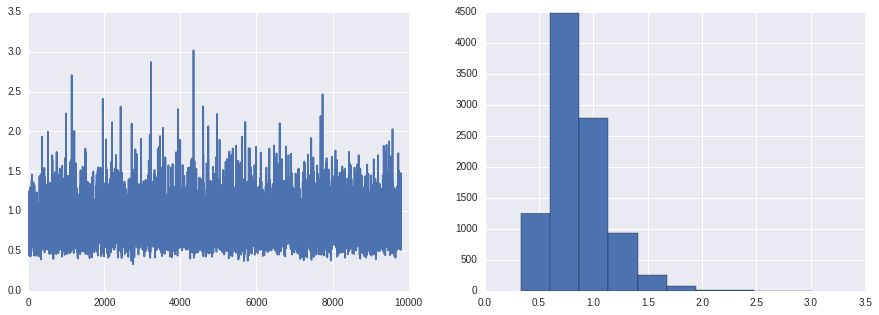

In [168]:
sigma_sample = M.trace('sigma_x')[:]
rho_sample = M.trace('rho')[:]

fig, ax = plt. subplots(1, 2, figsize = (15, 5))
ax[0].plot(sigma_sample)
ax[1].hist(sigma_sample)


Acutally, you don't have to waste your time on construction different subplots. `pymc`'s built-in plotting functionality creates pretty informative plots for you (baed on `matplotlib`). On the figure below
- Upper left subplot: trace, 
- Lower left subplot: autocorrelation (try to resample the model with `thin=1`), 
- Right subplot: histogram with the mean

Plotting rho


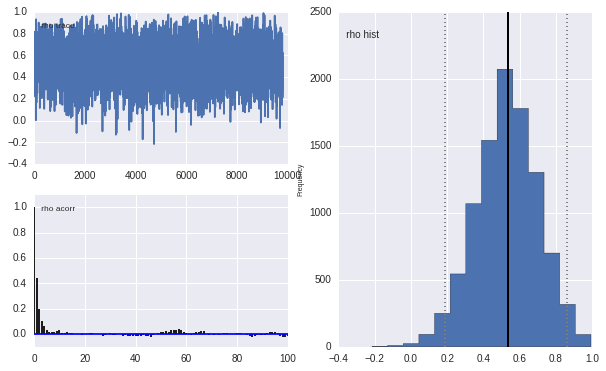

In [169]:
from pymc.Matplot import plot as fancy_plot
fancy_plot(M.trace('rho'))

For a non-graphical summary of the posterior use the `stats()` method

In [170]:
M.stats('rho')

# Try also: 
#M.summary()

{'rho': {'95% HPD interval': array([ 0.1894716,  0.8630899]),
  'mc error': 0.0029385342710042278,
  'mean': 0.5298227172415475,
  'n': 9800,
  'quantiles': {2.5: 0.1767998875856974,
   25: 0.41720379051147455,
   50: 0.53323473221261153,
   75: 0.64675882923717398,
   97.5: 0.85677266144745734},
  'standard deviation': 0.17113578794137885}}

In [171]:
N = len(rho_sample)
rho_pr = [rho.random() for i in range(N)]
sigma_pr = [sigma_x.random() for i in range(N)]

Prior = np.vstack([rho_pr, sigma_pr]).T
Posterior = np.vstack([rho_sample, sigma_sample]).T

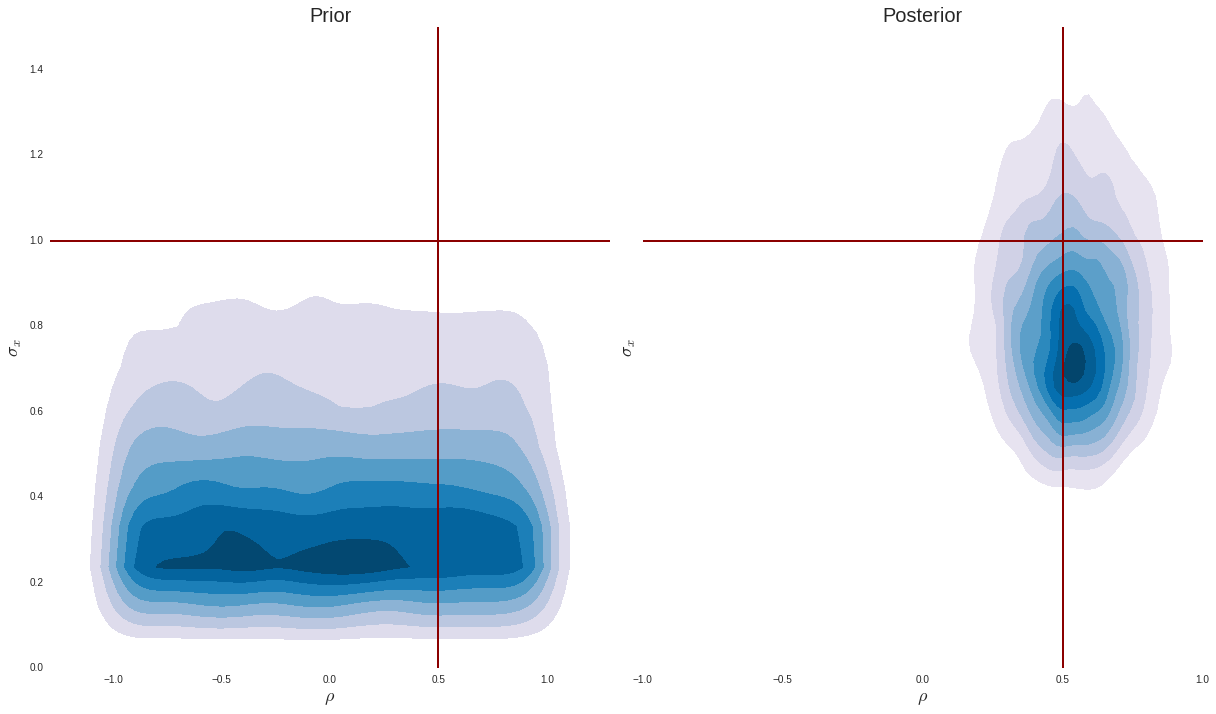

In [172]:
fig, bx = plt.subplots(1, 2, figsize = (17, 10), sharey = True)
sb.kdeplot(Prior, shade = True, cmap = 'PuBu', ax = bx[0])
bx[0].patch.set_facecolor('white')
bx[0].collections[0].set_alpha(0)
bx[0].axhline(y = sigma_x_true, color = 'DarkRed', lw =2)
bx[0].axvline(x = rho_true, color = 'DarkRed', lw =2)
bx[0].set_xlabel(r'$\rho$', fontsize = 18)
bx[0].set_ylabel(r'$\sigma_x$', fontsize = 18)
bx[0].set_title('Prior', fontsize = 20)

sb.kdeplot(Posterior, shade = True, cmap = 'PuBu', ax = bx[1])
bx[1].patch.set_facecolor('white')
bx[1].collections[0].set_alpha(0)
bx[1].axhline(y = sigma_x_true, color = 'DarkRed', lw =2)
bx[1].axvline(x = rho_true, color = 'DarkRed', lw =2)
bx[1].set_xlabel(r'$\rho$', fontsize = 18)
bx[1].set_ylabel(r'$\sigma_x$', fontsize = 18)
bx[1].set_title('Posterior', fontsize = 20)
plt.xlim(-1, 1)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.savefig('beamer/prior_post.pdf')

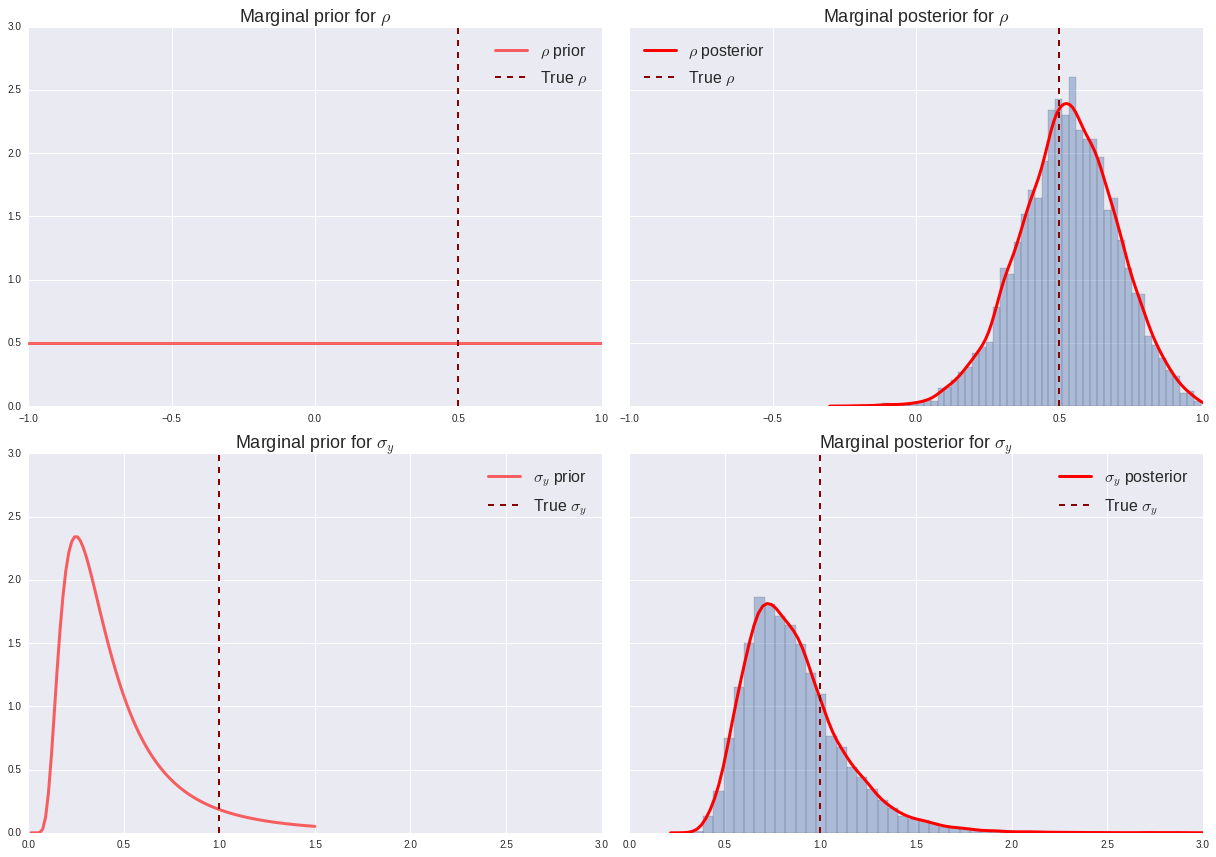

In [173]:
rho_grid = np.linspace(-1, 1, 100)
sigmay_grid = np.linspace(0, 1.5, 100)
U = sp.stats.uniform(-1, 2)
IG = sp.stats.invgamma(3)

fig2, cx = plt.subplots(2, 2, figsize = (17, 12), sharey = True)

cx[0, 0].plot(rho_grid, U.pdf(rho_grid), 'r-', lw = 3, alpha = 0.6, label = r'$\rho$ prior')
cx[0, 0].set_title(r"Marginal prior for $\rho$", fontsize = 18)
cx[0, 0].axvline(x = rho_true, color = 'DarkRed', lw = 2, linestyle = '--', label = r'True $\rho$')
cx[0, 0].legend(loc='best', fontsize = 16)
cx[0, 0].set_xlim(-1, 1)

sb.distplot(rho_sample, ax = cx[0,1], kde_kws={"color": "r", "lw": 3, "label": r"$\rho$ posterior"})
cx[0, 1].set_title(r"Marginal posterior for $\rho$", fontsize = 18)
cx[0, 1].axvline(x = rho_true, color = 'DarkRed',  lw = 2, linestyle = '--', label = r'True $\rho$')
cx[0, 1].legend(loc='best', fontsize = 16)
cx[0, 1].set_xlim(-1, 1)

cx[1, 0].plot(sigmay_grid, IG.pdf(sigmay_grid), 'r-', lw=3, alpha=0.6, label=r'$\sigma_y$ prior')
cx[1, 0].set_title(r"Marginal prior for $\sigma_y$", fontsize = 18)
cx[1, 0].axvline(x = sigma_x_true, color = 'DarkRed',  lw = 2, linestyle = '--', label = r'True $\sigma_y$')
cx[1, 0].legend(loc = 'best', fontsize = 16)
cx[1, 0].set_xlim(0, 3)

sb.distplot(sigma_sample, ax = cx[1,1], kde_kws={"color": "r", "lw": 3, "label": r"$\sigma_y$ posterior"})
cx[1, 1].set_title(r"Marginal posterior for $\sigma_y$", fontsize = 18)
cx[1, 1].axvline(x = sigma_x_true, color = 'DarkRed',  lw = 2, linestyle = '--', label = r'True $\sigma_y$')
cx[1, 1].legend(loc = 'best', fontsize = 16)
cx[1, 1].set_xlim(0, 3)
plt.tight_layout()
plt.savefig('beamer/marginal_prior_post.pdf')

## Sources and further reading:

`pymc` official documentation: https://pymc-devs.github.io/pymc/index.html

Rich set of fun examples (very easy read) -- **Probabilistic Programming & Bayesian Methods for Hackers**
http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/

Nice example about `potential`: http://healthyalgorithms.com/2008/11/05/mcmc-in-python-pymc-to-sample-uniformly-from-a-convex-body/

Non-trivial example comparing the Gibbs and Metropolis algorithms:
https://github.com/aflaxman/pymc-examples/blob/master/gibbs_for_uniform_ball.ipynb

Another example: https://users.obs.carnegiescience.edu/cburns/ipynbs/PyMC.html